最大化动作的熵,增强模型的稳定性

Q(state,action) + alpha * 熵[Q(static,*)]

训练过程中alpha应该递减.

为了缓解自举,会用两个value模型评估Q函数,取其中小的值.

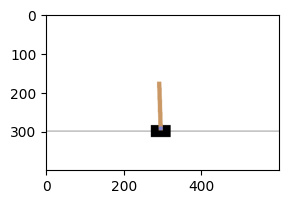

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch

model_action = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax(dim=1),
)

model_action(torch.randn(2, 4))

tensor([[0.4700, 0.5300],
        [0.4458, 0.5542]], grad_fn=<SoftmaxBackward0>)

In [3]:
model_value1 = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

model_value2 = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

model_value1_next = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

model_value2_next = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

model_value1_next.load_state_dict(model_value1.state_dict())
model_value2_next.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 4))

tensor([[ 0.0325, -0.0036],
        [ 0.0379,  0.0281]], grad_fn=<AddmmBackward0>)

In [4]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        prob = model_action(torch.FloatTensor(state).reshape(1, 4))[0].tolist()
        action = random.choices(range(2), weights=prob, k=1)[0]

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


16.0

In [5]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
state, action, reward, next_state, over = pool.sample()

len(pool), pool[0]

C:\Users\User\AppData\Local\Temp\ipykernel_59152\3891364554.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)


(202,
 (array([ 0.03273823, -0.01216186, -0.04639029,  0.04894773], dtype=float32),
  0,
  1.0,
  array([ 0.03249499, -0.20658898, -0.04541133,  0.32664078], dtype=float32),
  False))

In [6]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=2e-4)
optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=2e-3)
optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=2e-3)


def soft_update(_from, _to):
    for _from, _to in zip(_from.parameters(), _to.parameters()):
        value = _to.data * 0.995 + _from.data * 0.005
        _to.data.copy_(value)


def get_prob_entropy(state):
    prob = model_action(torch.FloatTensor(state).reshape(-1, 4))
    entropy = prob * (prob + 1e-8).log()
    entropy = -entropy.sum(dim=1, keepdim=True)

    return prob, entropy


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)


alpha = 1.0

In [7]:
def train_value(state, action, reward, next_state, over):
    requires_grad(model_value1, True)
    requires_grad(model_value2, True)
    requires_grad(model_action, False)

    #计算target
    with torch.no_grad():
        #计算动作的熵
        prob, entropy = get_prob_entropy(next_state)
        target1 = model_value1_next(next_state)
        target2 = model_value2_next(next_state)
        target = torch.min(target1, target2)

    #加权熵,熵越大越好
    target = (prob * target).sum(dim=1, keepdim=True)
    target = target + alpha * entropy
    target = target * 0.98 * (1 - over) + reward

    #计算value
    value = model_value1(state).gather(dim=1, index=action)
    loss = torch.nn.functional.mse_loss(value, target)
    loss.backward()
    optimizer_value1.step()
    optimizer_value1.zero_grad()

    value = model_value2(state).gather(dim=1, index=action)
    loss = torch.nn.functional.mse_loss(value, target)
    loss.backward()
    optimizer_value2.step()
    optimizer_value2.zero_grad()

    return loss.item()


train_value(state, action, reward, next_state, over)

2.6378400325775146

In [9]:
def train_action(state):
    requires_grad(model_value1, False)
    requires_grad(model_value2, False)
    requires_grad(model_action, True)

    #计算熵
    prob, entropy = get_prob_entropy(state)

    #计算value
    value1 = model_value1(state)
    value2 = model_value2(state)
    value = torch.min(value1, value2)

    #求期望求和
    value = (prob * value).sum(dim=1, keepdim=True)

    #加权熵
    loss = -(value + alpha * entropy).mean()

    loss.backward()
    optimizer_action.step()
    optimizer_action.zero_grad()

    return loss.item()


train_action(state)

-0.7007997632026672

In [10]:
def train():
    global alpha
    model_action.train()
    model_value1.train()
    model_value2.train()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        pool.update()

        #每次更新过数据后,学习N次
        for i in range(2000):
            #采样一批数据
            state, action, reward, next_state, over = pool.sample()

            #训练
            train_value(state, action, reward, next_state, over)
            train_action(state)
            soft_update(model_value1, model_value1_next)
            soft_update(model_value2, model_value2_next)

        alpha *= 0.95

        if epoch % 10 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), alpha, test_result)


train()

0 441 0.95 76.9
10 2795 0.5688000922764596 105.35
20 4985 0.34056162628811465 200.0
30 7151 0.20390682574579033 197.5
40 9151 0.12208654873684793 199.3
50 11274 0.07309772651287748 200.0
60 13274 0.04376630903760433 161.1
70 15548 0.02620450591493621 200.0
80 17548 0.015689605665762895 200.0
90 19548 0.009393946474176 199.25
100 20000 0.0056245027593172965 185.55
110 20000 0.003367597566851453 200.0
120 20000 0.0020163050597632503 200.0
130 20000 0.0012072363200535043 200.0
140 20000 0.0007228169792062388 200.0
150 20000 0.0004327772257594741 200.0
160 20000 0.00025911971152330434 199.5
170 20000 0.00015514454297379488 200.0
180 20000 9.289076879966704e-05 200.0
190 20000 5.561713459461251e-05 200.0


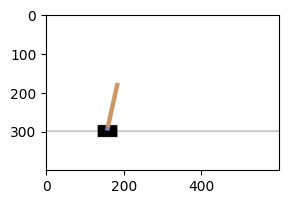

188.0

In [11]:
play(True)[-1]